In [43]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

In [44]:
ny_set = 400
nx_set = 400
@dataclass
class Config:
    nx: int = nx_set
    ny: int = ny_set
    steps: int = 50000
    output_stride: int = 5000
    molecular_weights: tuple[float, float, float] = (1, 1)
    pressure_frac: tuple[float, float, float] = (0.95, 0.05)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 5

    v_0 = 0.15
    record_flow = 100

In [45]:
def initialise_chamber(config: Config, absorption_coefficient, ini_slope):
    nx, ny = config.nx, config.ny
    species = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float32)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float32)
    pressure = xp.array(config.pressure_frac, dtype=xp.float32) * config.total_pressure
    for s in range(species):
        psigma[s, :, :] = pressure[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    lx = nx
    x_coord = xp.linspace(0.0, lx, nx)
    kx = 2*xp.pi/nx
    ly = ny
    y_coord = xp.linspace(0.0, ly, ny)
    ky = 2*xp.pi /ly

    profile_x = xp.sin(kx*x_coord) * xp.cos(ky*y_coord)
    profile_y = xp.sin(ky*y_coord) * xp.cos(kx*x_coord)


    f = xp.zeros((species, 9, nx, ny), dtype=xp.float32)
    ux_s = -xp.ones((species, nx, ny), dtype=xp.float32) * profile_y[None, None, :] * config.v_0
    uy_s = xp.ones((species, nx, ny), dtype=xp.float32) * profile_x[None, :, None] * config.v_0
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [46]:
def main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, ini_slope, Config):
    cfg = Config()

    f, phi = initialise_chamber(cfg, absorption_coefficient, ini_slope)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float32)

    velocity_field = []
    for step in tqdm(range(cfg.steps + 1)):
        #f_old = xp.copy(f)

        if step % cfg.output_stride == 0:
            #save_concentration_frames(f, phi, step, molecular_weights)
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 0.3, skip = 10, save = False)

        if step % cfg.record_flow == 0:
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            np.save(f"vortex_flow", np.array(velocity_field))

        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream, step,
                     non_absorb_mask, bc_top, bc_bottom)

    return f

  0%|          | 0/50001 [00:00<?, ?it/s]

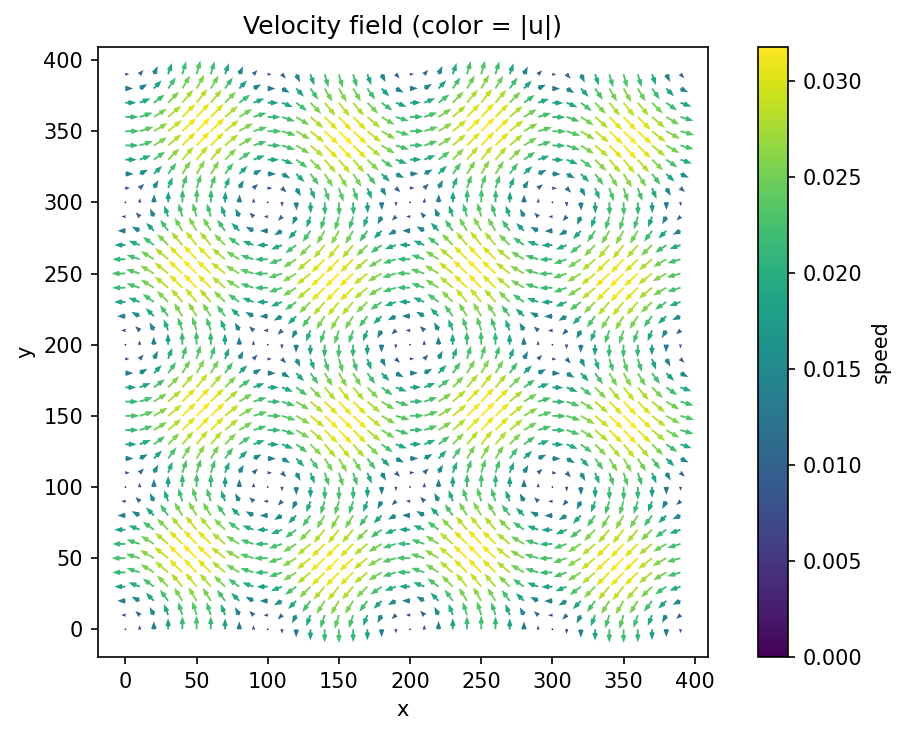

 10%|▉         | 4996/50001 [01:05<09:13, 81.30it/s]

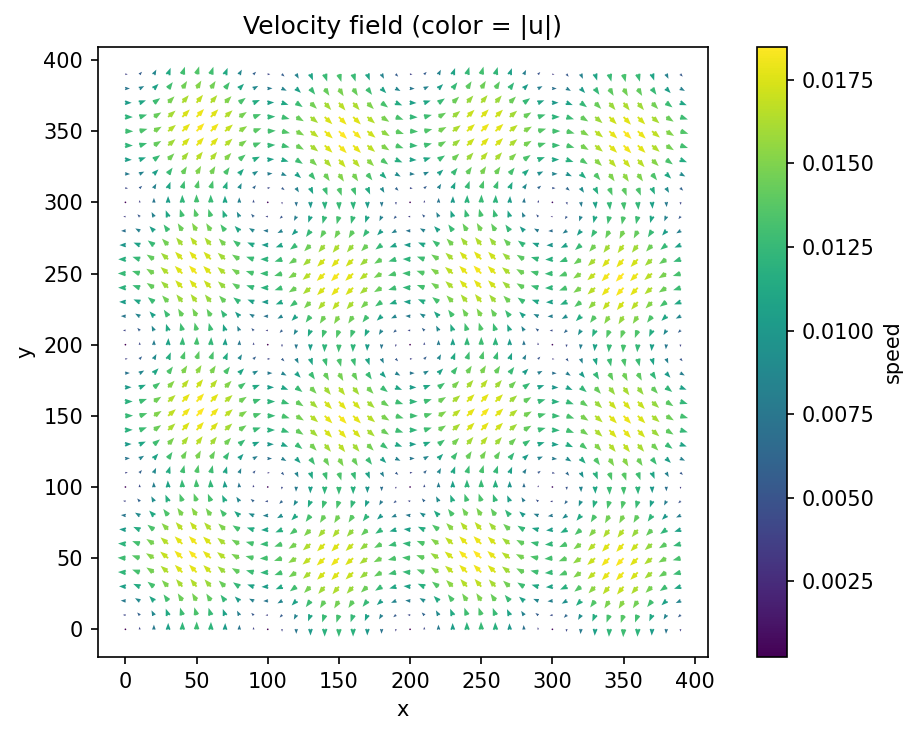

 20%|█▉        | 9995/50001 [02:13<08:19, 80.03it/s]

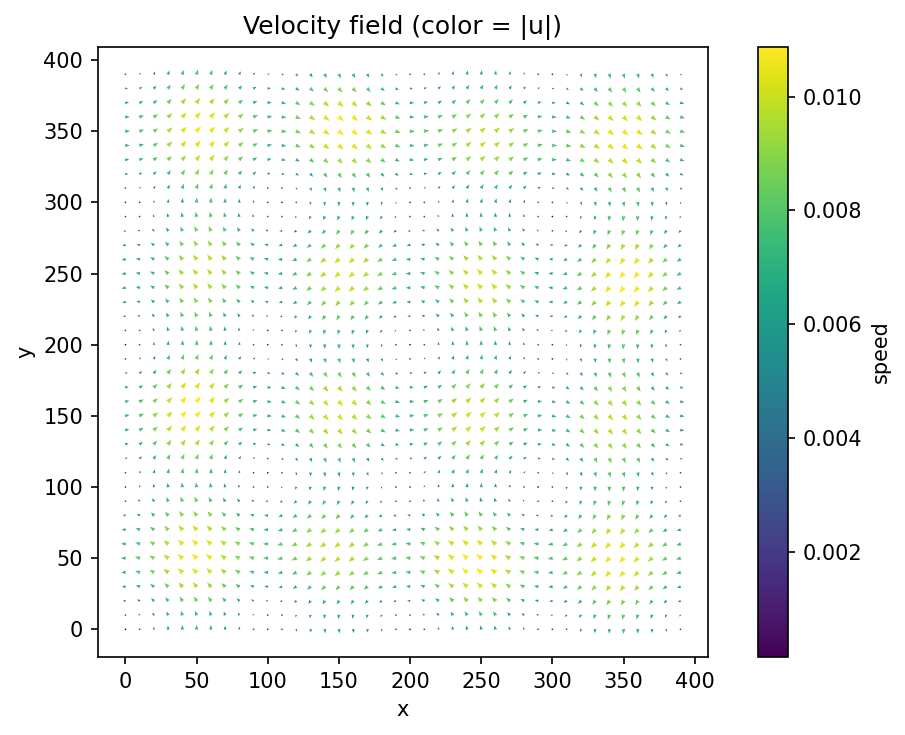

 30%|██▉       | 15000/50001 [03:26<07:22, 79.11it/s]

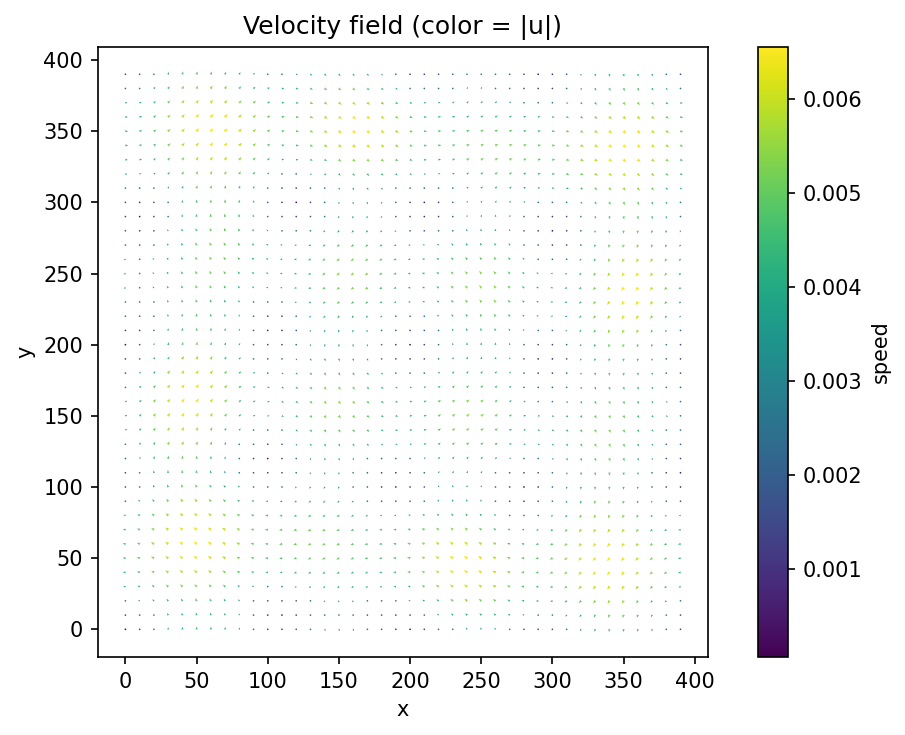

 40%|███▉      | 19993/50001 [04:44<06:06, 81.83it/s]

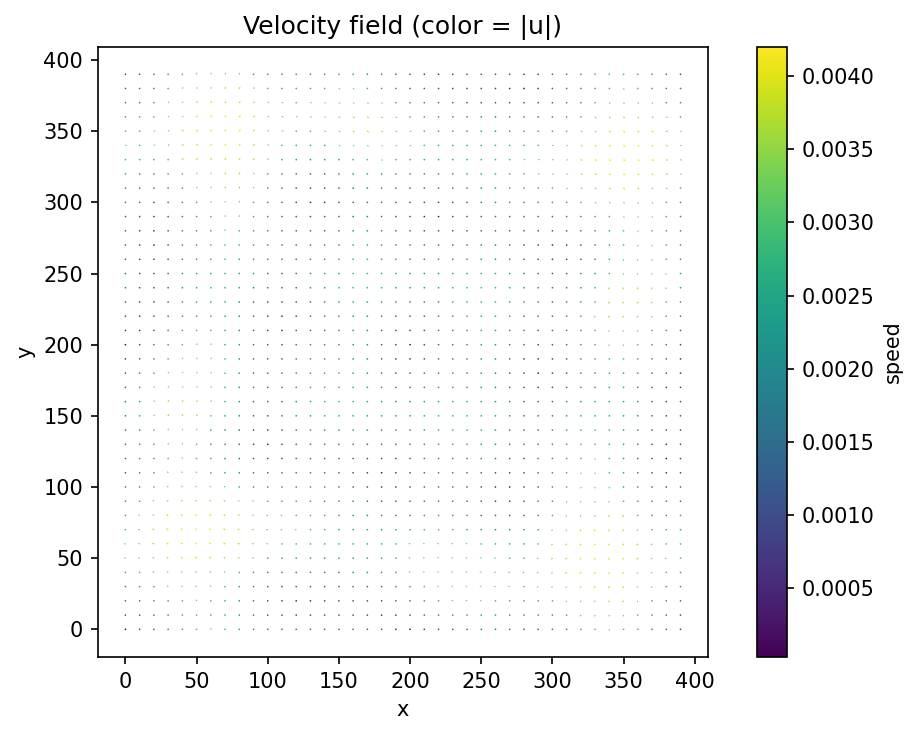

 50%|████▉     | 24998/50001 [06:07<05:24, 76.98it/s]

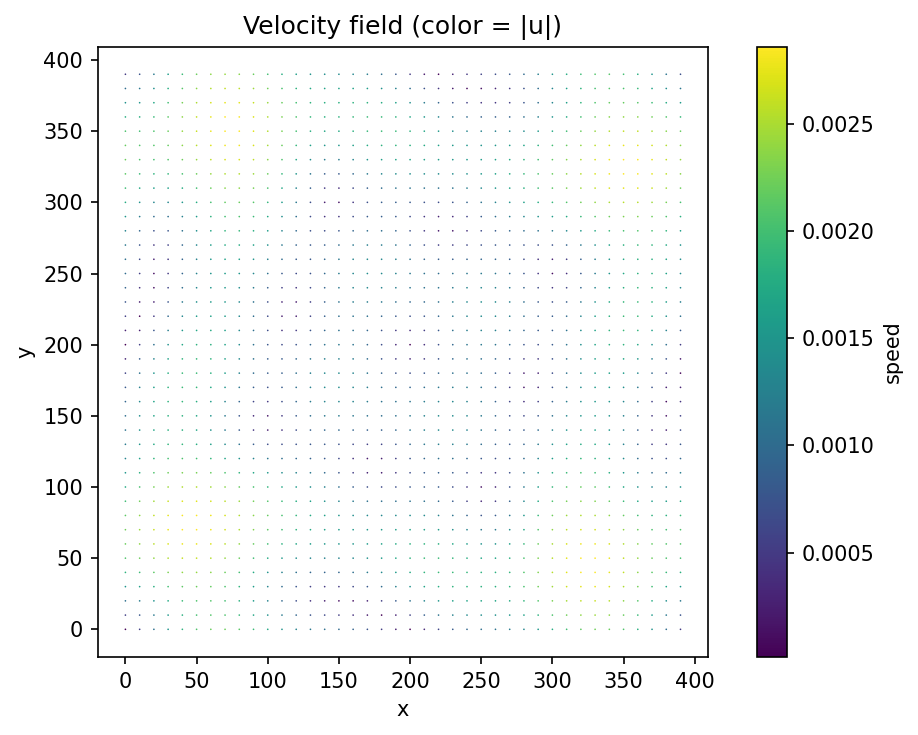

 60%|█████▉    | 29999/50001 [07:35<04:07, 80.90it/s]

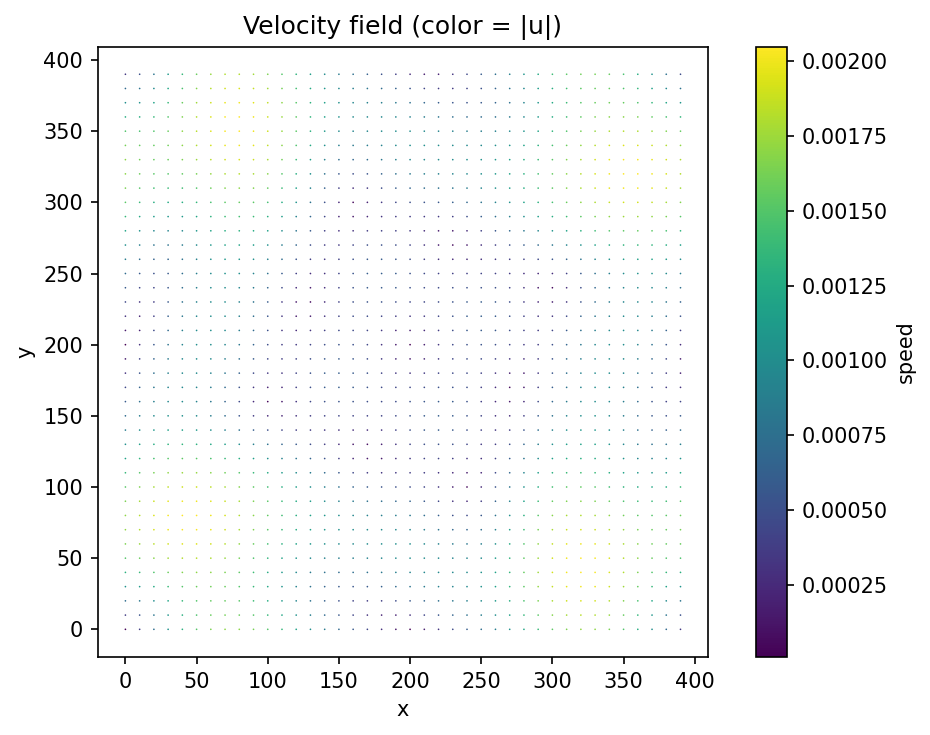

 70%|██████▉   | 34995/50001 [09:08<03:11, 78.48it/s]

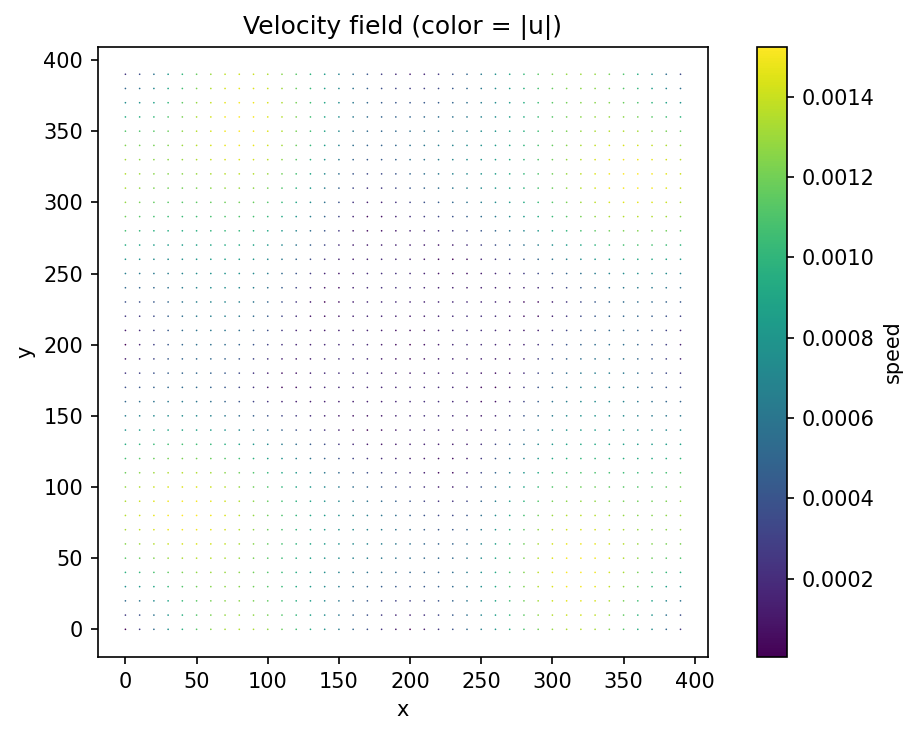

 75%|███████▍  | 37400/50001 [09:55<03:20, 62.81it/s]


KeyboardInterrupt: 

In [47]:
absorption_coefficient = 100
bc_top = None
bc_bottom = None
non_absorb_mask = None

f= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)

In [48]:
vortex_flow = np.load("vortex_flow.npy")

In [49]:
print(vortex_flow.shape)
# frames, components, species, nx, ny
vx_profile = vortex_flow[:, 0, 0, nx_set//2, :]
print(vx_profile.shape)

(374, 2, 2, 400, 400)
(374, 400)


(374,)


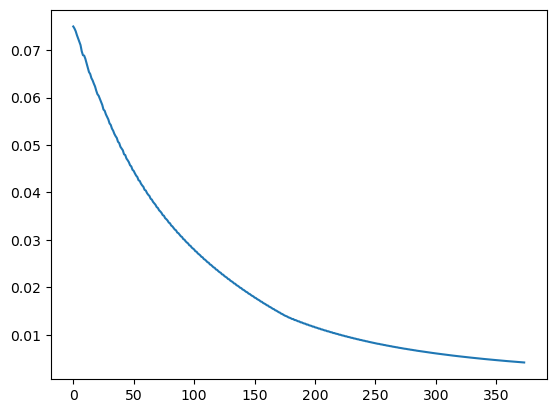

In [50]:
max_velocity_decay_profile = np.max(vortex_flow, axis=(1,2,3,4))
print(max_velocity_decay_profile.shape)
plt.plot(max_velocity_decay_profile)

In [51]:
ly = ny_set
lx = nx_set
k_2 = (2*xp.pi /ly)**2 + (2*xp.pi /lx)**2
i = len(max_velocity_decay_profile)-1
t = i * Config.record_flow
mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k_2)
print(mu)

0.15705211827085103


0.18756895083026434


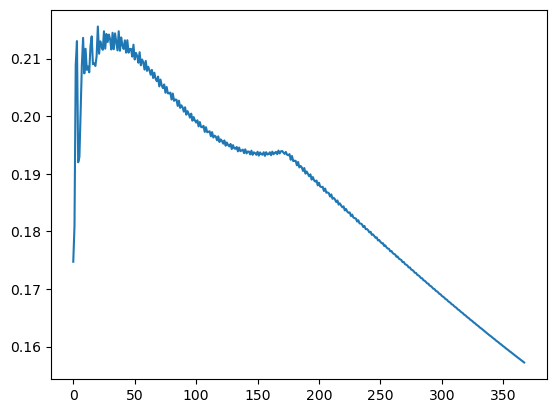

In [52]:
mu_lsit = []
for i in range(5, len(max_velocity_decay_profile)-1):
    t = i * Config.record_flow
    mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k_2)
    mu_lsit.append(mu)
plt.plot(mu_lsit)
print(np.mean(mu_lsit))

nx = 200:

m = 1, nB = 9, mu = 0.054. measured = 0.077

m = 2, nB = 9, mu = 0.076. measured = 0.13

nx = 400: (smaller gradient)

m = 1, nB = 9, mu = 0.054. measured  = 0.059
m = 1, nB = 5, mu = 0.11. measured = 0.20

In [42]:
nb_table = np.array([0.50,0.60,0.72,0.87,1.05,1.26,1.51,1.82,2.19,2.63,3.16,3.80,4.57,5.49,6.61,7.95,9.56,11.5,13.8,16.6,], dtype = np.float32)
predict_lambda = 10 * nb_table[Config.nB] * (1/Config.molecular_weights[0]/3) * 1/np.sqrt(1/Config.molecular_weights[0] + 1/Config.molecular_weights[1])
print('lambda = ',predict_lambda)

relaxation = predict_lambda/(1+predict_lambda/2)
print('relaxation = ',relaxation)

viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)


lambda =  2.96984845850518
relaxation =  1.1951464851700708
viscosity_kinematic =  0.11223917246643307


In [57]:
import numpy as np

def compute_vorticity(vel, dx=1.0, dy=1.0):
    """
    vel: array (t, 2, nx, ny) where vel[:,0]=vx and vel[:,1]=vy
    Returns: omega (t, nx, ny) with omega = d(vy)/dx - d(vx)/dy
    """
    vx = vel[:, 0]  # (t, nx, ny)
    vy = vel[:, 1]

    dvy_dx = np.gradient(vy, dx, axis=-2)  # derivative along nx-axis
    dvx_dy = np.gradient(vx, dy, axis=-1)  # derivative along ny-axis

    return dvy_dx - dvx_dy

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_vorticity_with_ipywidgets(vel, dx=1.0, dy=1.0, fixed_clim=True, origin="lower"):
    omega = compute_vorticity(vel, dx=dx, dy=dy)
    T = omega.shape[0]

    fig, ax = plt.subplots()
    im = ax.imshow(omega[0], origin=origin)
    plt.colorbar(im, ax=ax)
    ax.set_title("Vorticity (t = 0)")

    if fixed_clim:
        m = np.nanmax(np.abs(omega))
        im.set_clim(-m, m)

    slider = widgets.IntSlider(value=0, min=0, max=T-1, step=1, description="t")
    display(slider)

    def _on_change(change):
        ti = change["new"]
        im.set_data(omega[ti])
        ax.set_title(f"Vorticity (t = {ti})")
        if not fixed_clim:
            im.autoscale()
        fig.canvas.draw_idle()

    slider.observe(_on_change, names="value")
    plt.show()

# Example (in Jupyter):
# plot_vorticity_with_ipywidgets(vel, dx=1.0, dy=1.0)



IntSlider(value=0, description='t', max=373)

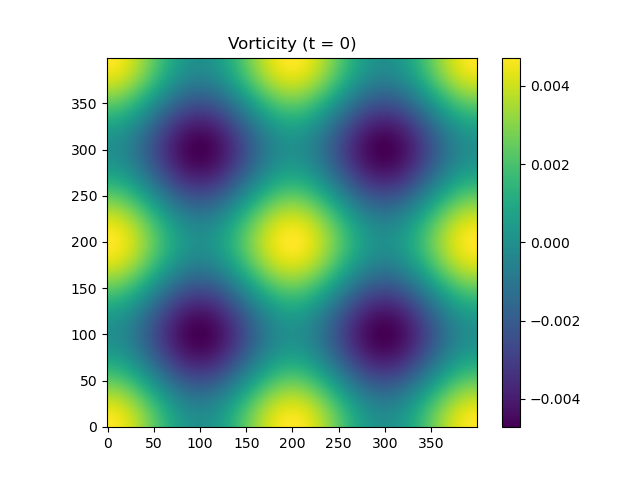

In [62]:
%matplotlib widget
plot_vorticity_with_ipywidgets(vortex_flow[0:, :, 0, :, :], dx=1.0, dy=1.0)